# Information Extraction

In [1]:
# Helper libraries
import warnings

# Scientific and visual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from emot import UNICODE_EMOJI, EMOTICONS_EMO
from nltk.corpus import stopwords
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.preprocessing import MinMaxScaler

# Local Modules
from youtube_analysis.paths import TRANSFORMED_DATA_DIR
from youtube_analysis.edautils import plot_pie, plot_cat

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

We have seen that viewer comments in our youtube episode video can be used to extract sentiment in the same way of rule-based unsupervised technique. We also have used Youtube API to extract number of likes per each comment. We finally create new features from textual data. But how, exactly, can we understand what happen in these comments?

A good and simple method is to ask intuitive questions, and anwser them by querying or plotting our dataframe.

Let's get started.

In [2]:
corpus = pd.read_pickle(TRANSFORMED_DATA_DIR / "improved_sentiment_corpus.pkl")

In [3]:
corpus.head()

,author,published_at,updated_at,likes,text,cleaned_text,filtered_text,lemmatized_text,sent_class,sent_score,has_emojis,has_emoticons
0,Lex Fridman,2022-12-29 17:34:04+00:00,2022-12-29 17:34:04+00:00,194,Here are the timestamps. Please chec...,here are the timestamps please che...,timestamps please check sponsors sup...,timestamps please check sponsor supp...,positive,0.9922,0,1
1,John Dickinson,2023-11-19 10:59:46+00:00,2023-11-19 10:59:46+00:00,0,Protein research is a major new brea...,protein research is a major new brea...,protein research major new breakthrough,protein research major new breakthrough,neutral,0.0000,0,0
2,John Dickinson,2023-11-19 10:50:38+00:00,2023-11-19 10:50:38+00:00,0,This is a good one.,this is a good one,good one,good one,positive,0.4404,0,0
3,john g henderson,2023-11-18 03:47:08+00:00,2023-11-18 03:49:31+00:00,0,A very interesting conversation unti...,a very interesting conversation unti...,interesting conversation end answer ...,interesting conversation end answer ...,negative,-0.8960,0,0
4,arife dickerson,2023-11-17 20:49:24+00:00,2023-11-17 20:49:24+00:00,0,This chick is always in Bilderberg g...,this chick is always in bilderberg g...,chick always bilderberg group meetin...,chick always bilderberg group meetin...,neutral,0.0000,0,0


### What is the global sentiment proportion ?

We can ask the most important question:

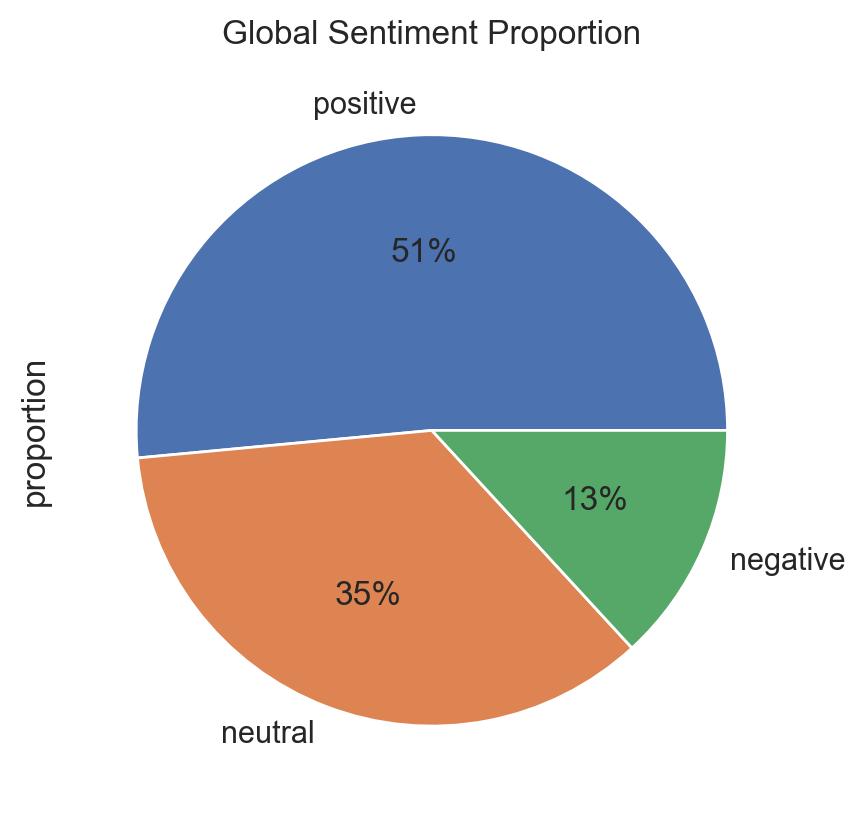

In [4]:
plt.title("Global Sentiment Proportion")
plot_pie(corpus, "sent_class")

### What are the connections between Likes and Sentiments ?

In [5]:
(corpus
  .groupby("sent_class")[["likes"]]
  .agg(func=np.mean)
)

,likes
sent_class,
negative,0.3074
neutral,1.1186
positive,4.6572


In [6]:
corpus.groupby("sent_class").describe()[[("likes", "min"), ("likes", "max")]]

likes       
             min    max
sent_class             
negative     0.0    3.0
neutral      0.0  303.0
positive     0.0  369.0

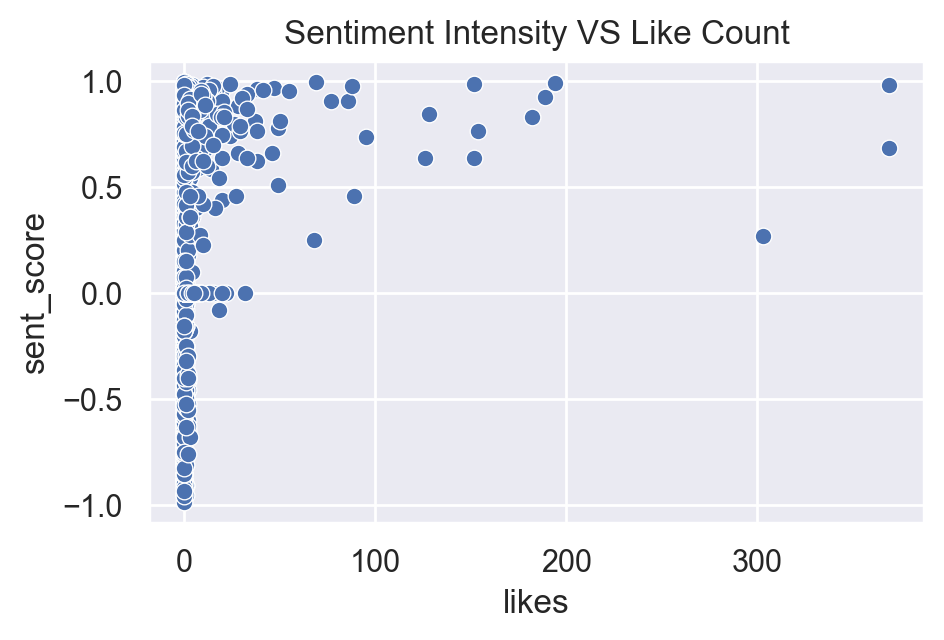

In [7]:
plt.figure(figsize=(5, 3))
plt.title("Sentiment Intensity VS Like Count")
sns.scatterplot(data=corpus, x="likes", y="sent_score")
plt.show()

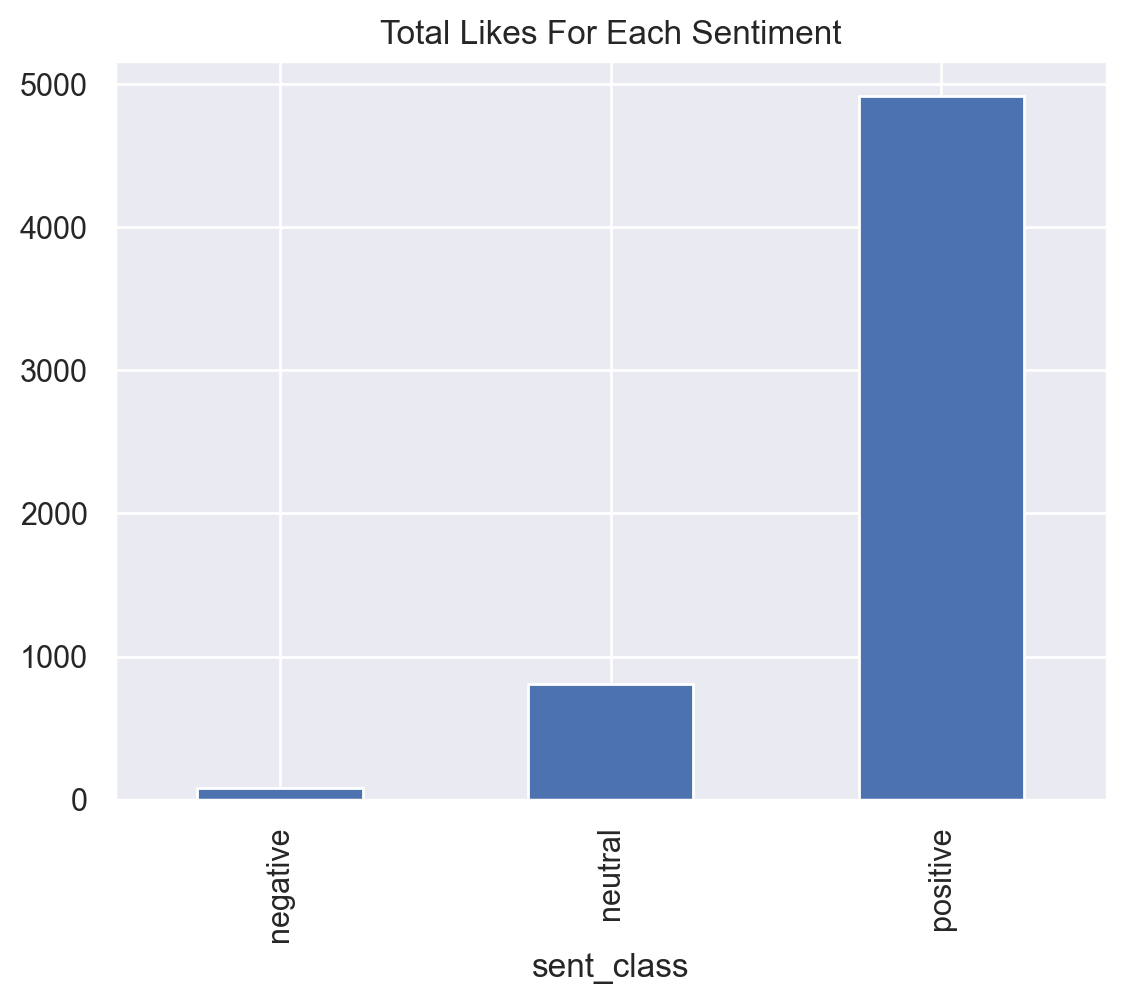

In [8]:
plt.title("Total Likes For Each Sentiment")
corpus.groupby("sent_class")["likes"].sum().plot.bar()
plt.show()

### How many comments contain “thank” and how are their sentiments?

In [9]:
corpus.cleaned_text.str.contains("thank").sum()

169

In [10]:
thank_index = [i for i, v in enumerate(corpus.cleaned_text.str.contains("thank")) if v]
thank_corpus = corpus.iloc[thank_index]

In [11]:
np.round(thank_corpus.sent_class.value_counts(normalize=True), 2)

sent_class
positive    0.94
neutral     0.05
negative    0.01
Name: proportion, dtype: float64

### What is the proportion of people using emojis or emoticons?

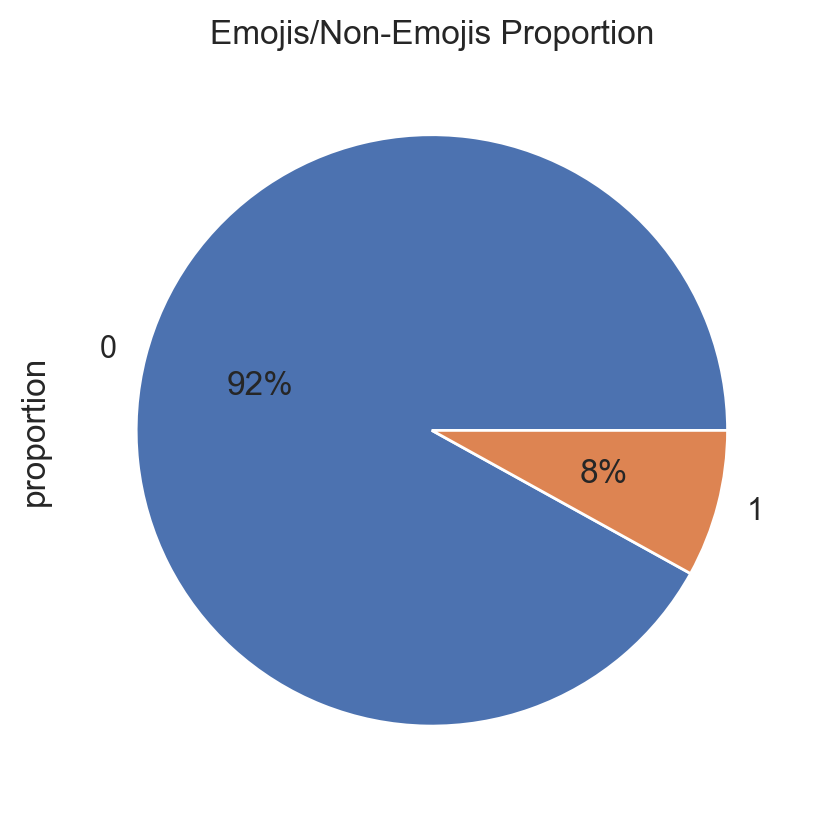

In [12]:
plt.title("Emojis/Non-Emojis Proportion")
plot_pie(corpus, "has_emojis")

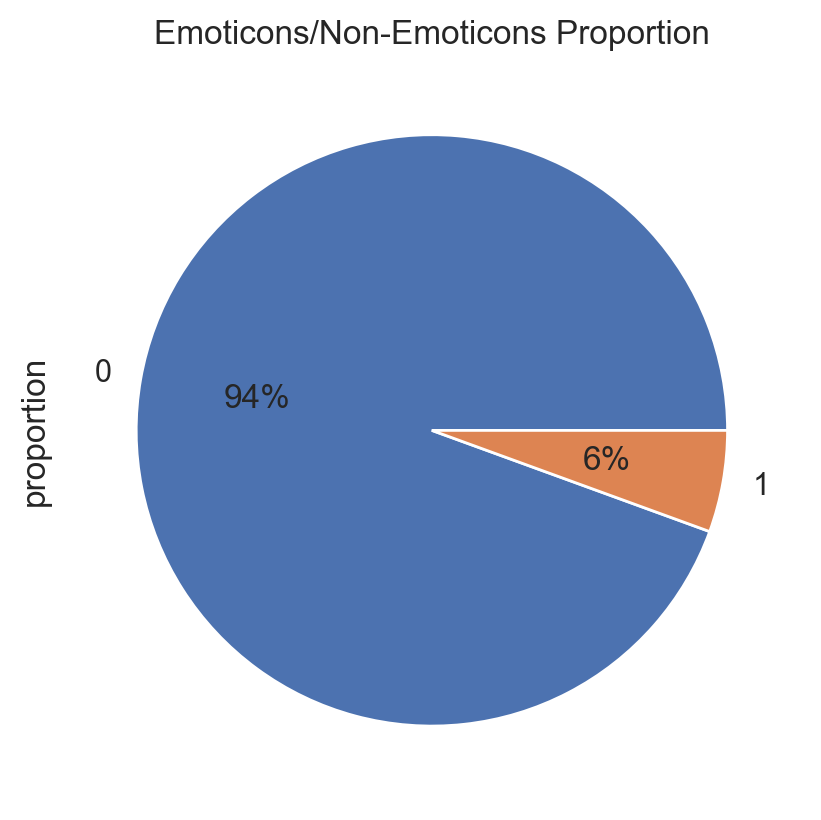

In [13]:
plt.title("Emoticons/Non-Emoticons Proportion")
plot_pie(corpus, "has_emoticons")

### What are the relations between emojis/emoticons and likes ?

In [14]:
corpus.groupby(["has_emojis"])[["likes"]].mean()

,likes
has_emojis,
0,3.0042
1,0.8848


In [15]:
corpus.groupby(['has_emoticons'])[['likes']].mean()

,likes
has_emoticons,
0,2.5787
1,7.1667


### What are the relations between emojis/emoticons and sentiments ?

In [16]:
pd.crosstab(corpus.sent_class, corpus.has_emojis)

has_emojis,0,1
sent_class,,
negative,261,9
neutral,674,51
positive,951,105


In [17]:
pd.crosstab(corpus.sent_class, corpus.has_emoticons)

has_emoticons,0,1
sent_class,,
negative,262,8
neutral,691,34
positive,984,72


### Who is the top commenter and what is its majority sentiment ?

In [18]:
corpus.author.describe()

count          2051
unique         1705
top       Dave Pyne
freq             16
Name: author, dtype: object

In [19]:
top_viewer_name = corpus.author.describe()["top"]
top_viewer_name

'Dave Pyne'

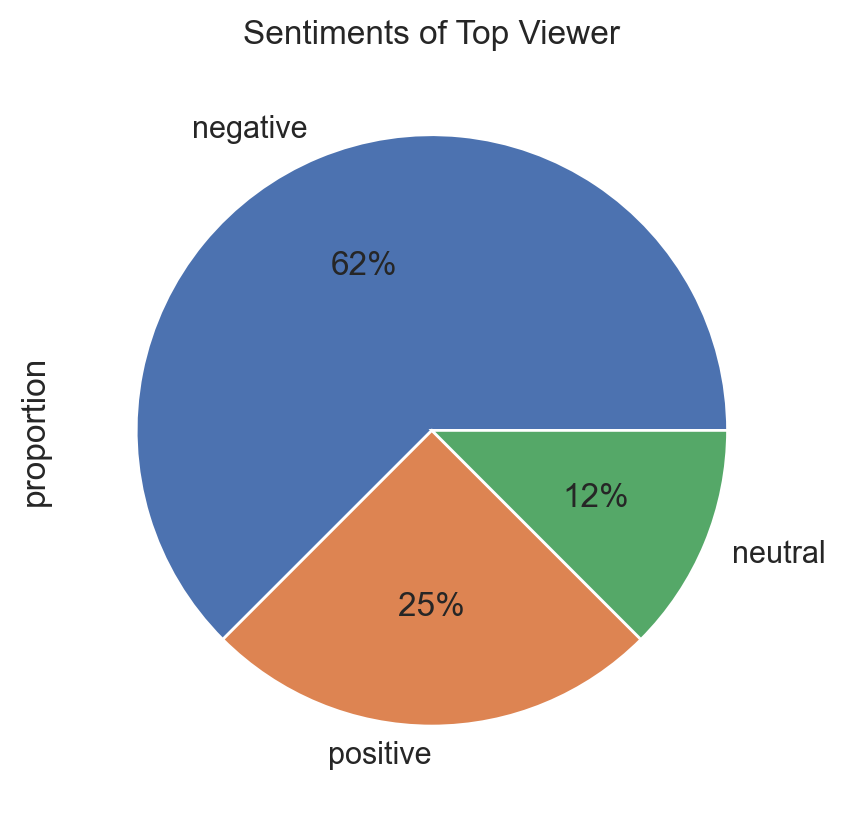

In [20]:
top_commenter = corpus[corpus.author==top_viewer_name]
plt.title("Sentiments of Top Viewer")
plot_pie(top_commenter, "sent_class")

What is he saying that is so negative ?

In [21]:
for text in top_commenter[top_commenter.sent_class=="negative"].text:
    print(text)
    print("-----------------------------------------------")

I think the moon is made of green cheese. You think there are aliens. I have been proven wrong. Have you been proven right? Doubtful.
-----------------------------------------------
The road to hell is paved with good intentions.
-----------------------------------------------
The fear of suffering is not the same as actually suffering and your no fear, may mean actual suffering for others.
-----------------------------------------------
You have seen nothing of atrocities like you will see, and the young people of today are running headlong into atrocities in the attempt to prove themselves better than our elders. Go woke, go broke, go dead.
-----------------------------------------------
I'll wait another 10000 years for humans to choose a way to live, that doesn't involve violence, because it will be a lot less time than you will take to seed a planet, we can never get to or communicate with to see if you are right. Don't get me wrong, I think you are brilliant, but very, very impra

### What are the most important topics of the top 3 commenter?

In [22]:
corpus.sort_values(by="likes", ascending=False).head(3)

,author,published_at,updated_at,likes,text,cleaned_text,filtered_text,lemmatized_text,sent_class,sent_score,has_emojis,has_emoticons
1335,Julian Lineham,2022-12-31 15:12:30+00:00,2022-12-31 15:12:30+00:00,369,"Every interview is amazing, but this...",every interview is amazing but thi...,every interview amazing conversation...,every interview amazing conversation...,positive,0.6858,0,0
1974,Ulysses,2022-12-29 18:54:06+00:00,2022-12-29 18:54:06+00:00,369,As a Turkish and someone who has bee...,as a turkish and someone who has bee...,turkish someone following channel qu...,turkish someone following channel qu...,positive,0.9820,0,0
2008,No One,2022-12-29 18:03:32+00:00,2022-12-29 18:03:32+00:00,303,Lex taking himself less seriously wi...,lex taking himself less seriously wi...,lex taking less seriously podcast like,lex taking le seriously podcast like,neutral,0.2716,0,0


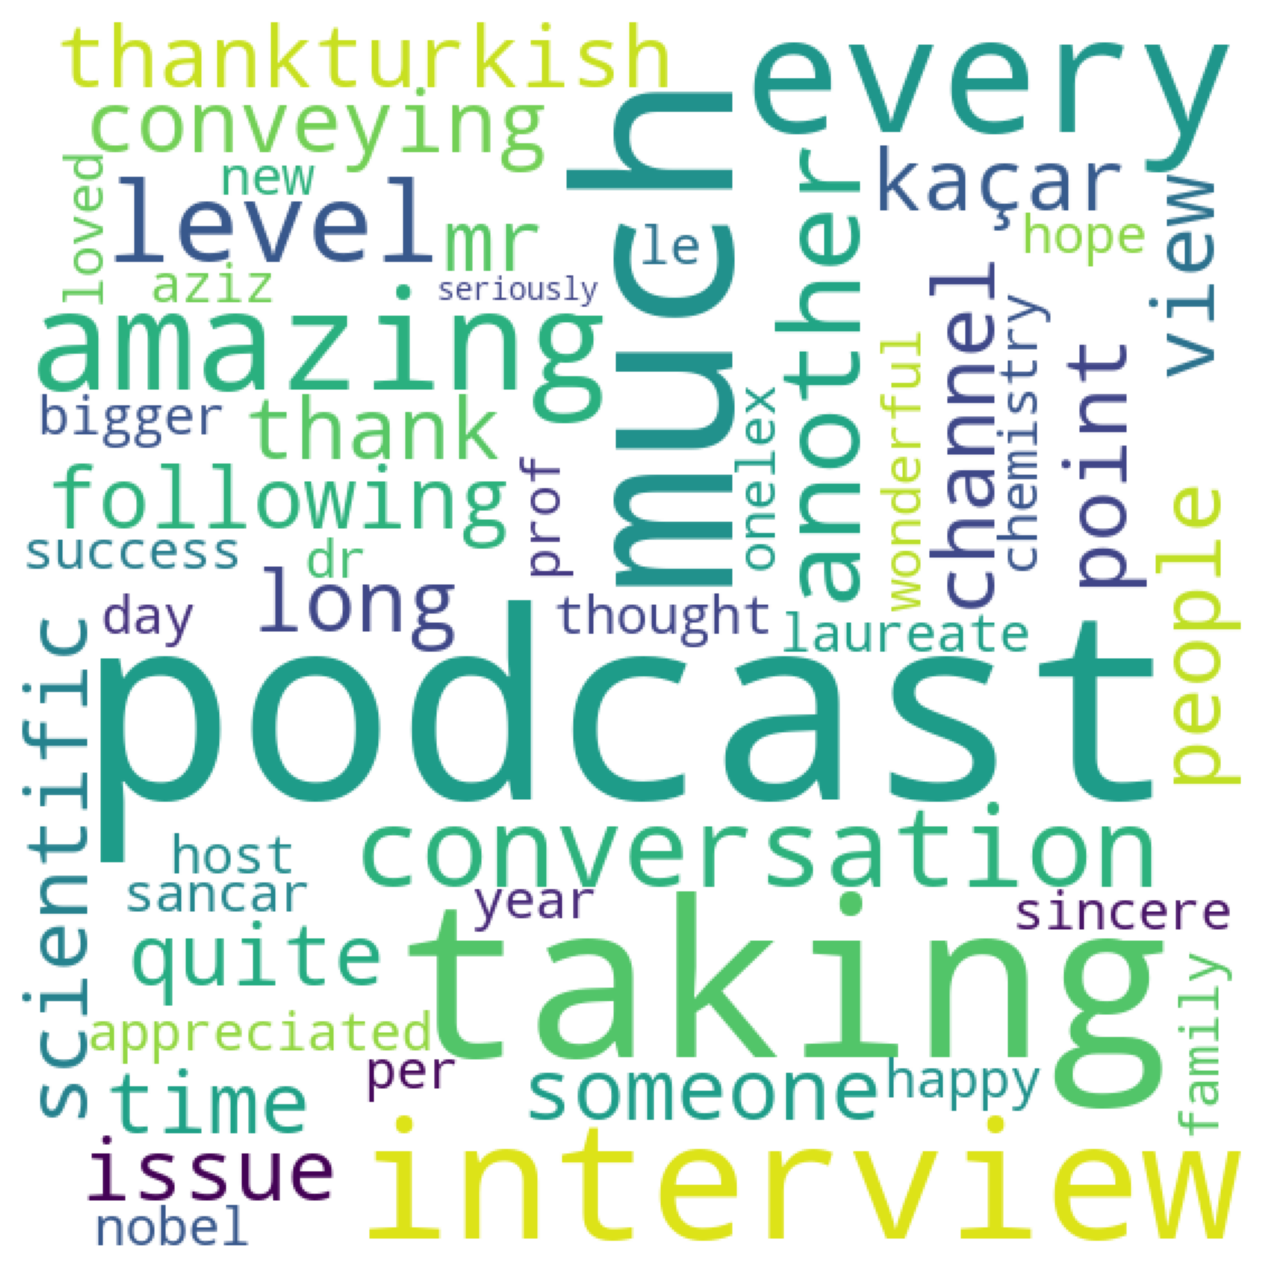

In [23]:
top_3_commenters_content = (
    corpus.sort_values(by="likes", ascending=False).head(3).lemmatized_text
)
top_terms = "".join([item for item in top_3_commenters_content])
stopword_list = set(STOPWORDS)

word_cloud = WordCloud(
    width=550,
    height=550,
    background_color="white",
    stopwords=stopword_list,
    min_font_size=10,
).generate(top_terms)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

What if we did the same thing with the negative sentiment cluster?

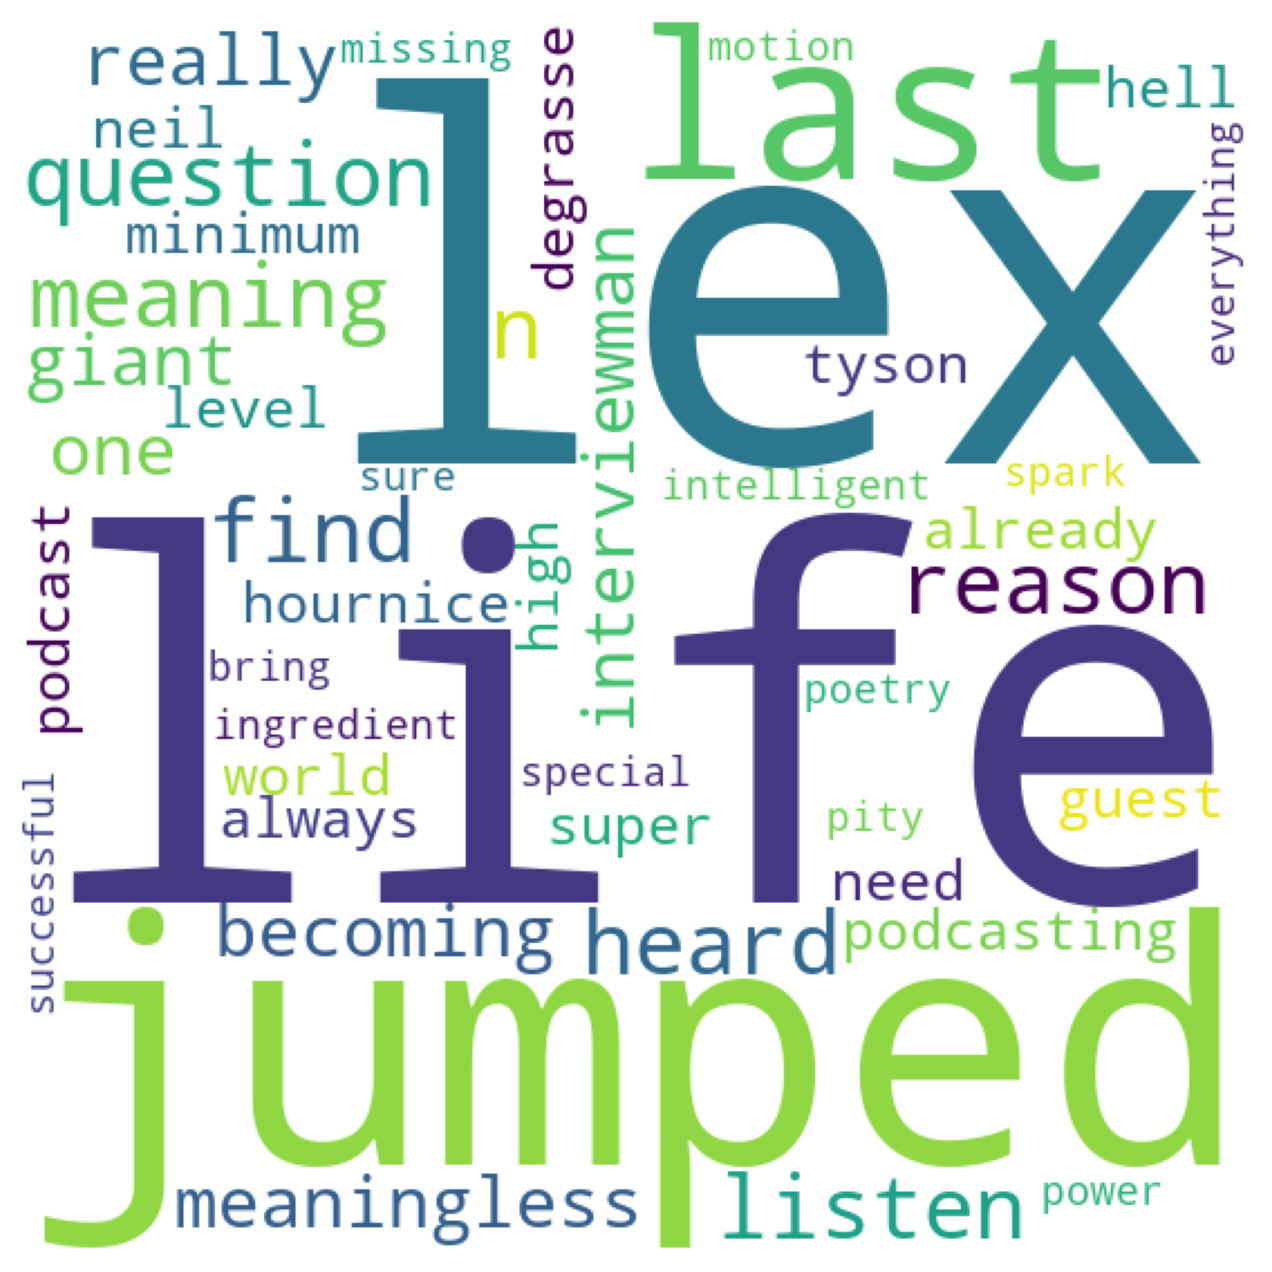

In [24]:
neg_top_3_commenters = (
    corpus[corpus.sent_class == "negative"]
    .sort_values(by="likes", ascending=False)
    .head(3)
    .lemmatized_text
)
top_terms = "".join([item for item in neg_top_3_commenters])

word_cloud = WordCloud(
    width=550,
    height=550,
    background_color="white",
    stopwords=stopword_list,
    min_font_size=10,
).generate(top_terms)

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

### How engagement run over time?

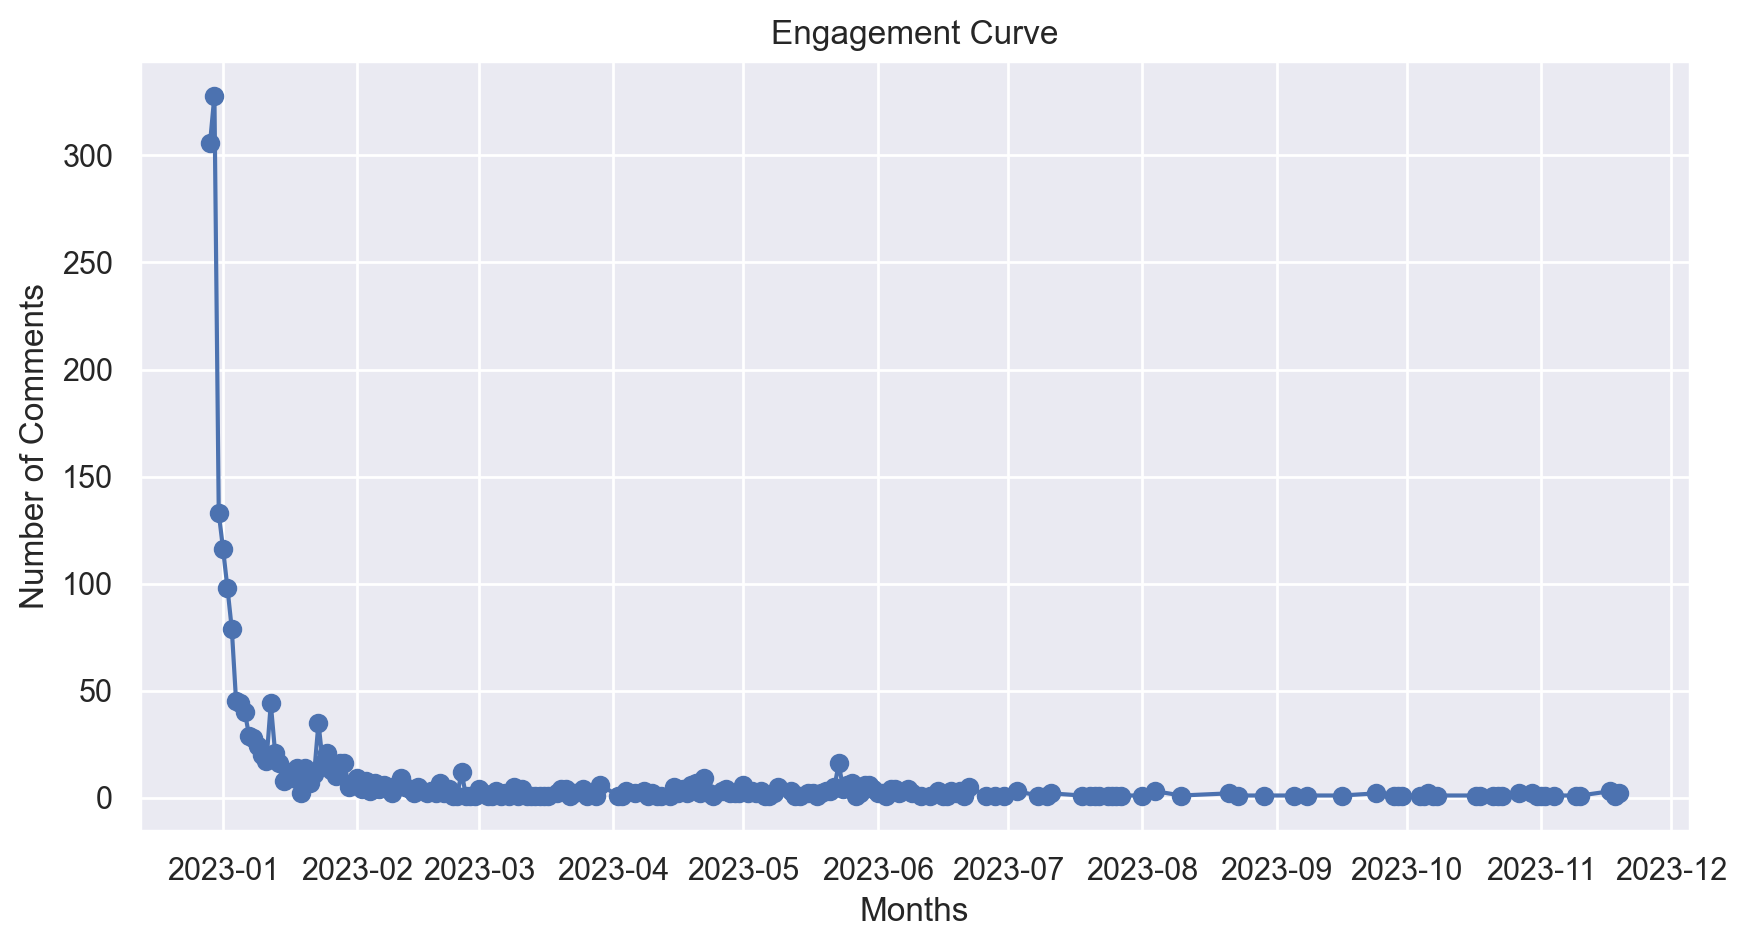

In [25]:
n_comments_over_time = corpus.groupby(corpus["published_at"].dt.date).size()

plt.figure(figsize=(10, 5))
plt.plot(
    n_comments_over_time.index,
    n_comments_over_time.values,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Engagement Curve")
plt.xlabel("Months")
plt.ylabel("Number of Comments")
plt.grid(True)
plt.show()

In [26]:
# Number of Likes and Comments
n_comments_over_time = corpus.groupby(corpus["published_at"].dt.date).agg({'likes': 'sum', 'published_at': 'size'})

In [27]:
# Let's normalize the variables:
scaler = MinMaxScaler()
normalized_comments_over_time = n_comments_over_time.copy()
normalized_comments_over_time[["published_at","likes"]] = scaler.fit_transform(normalized_comments_over_time)

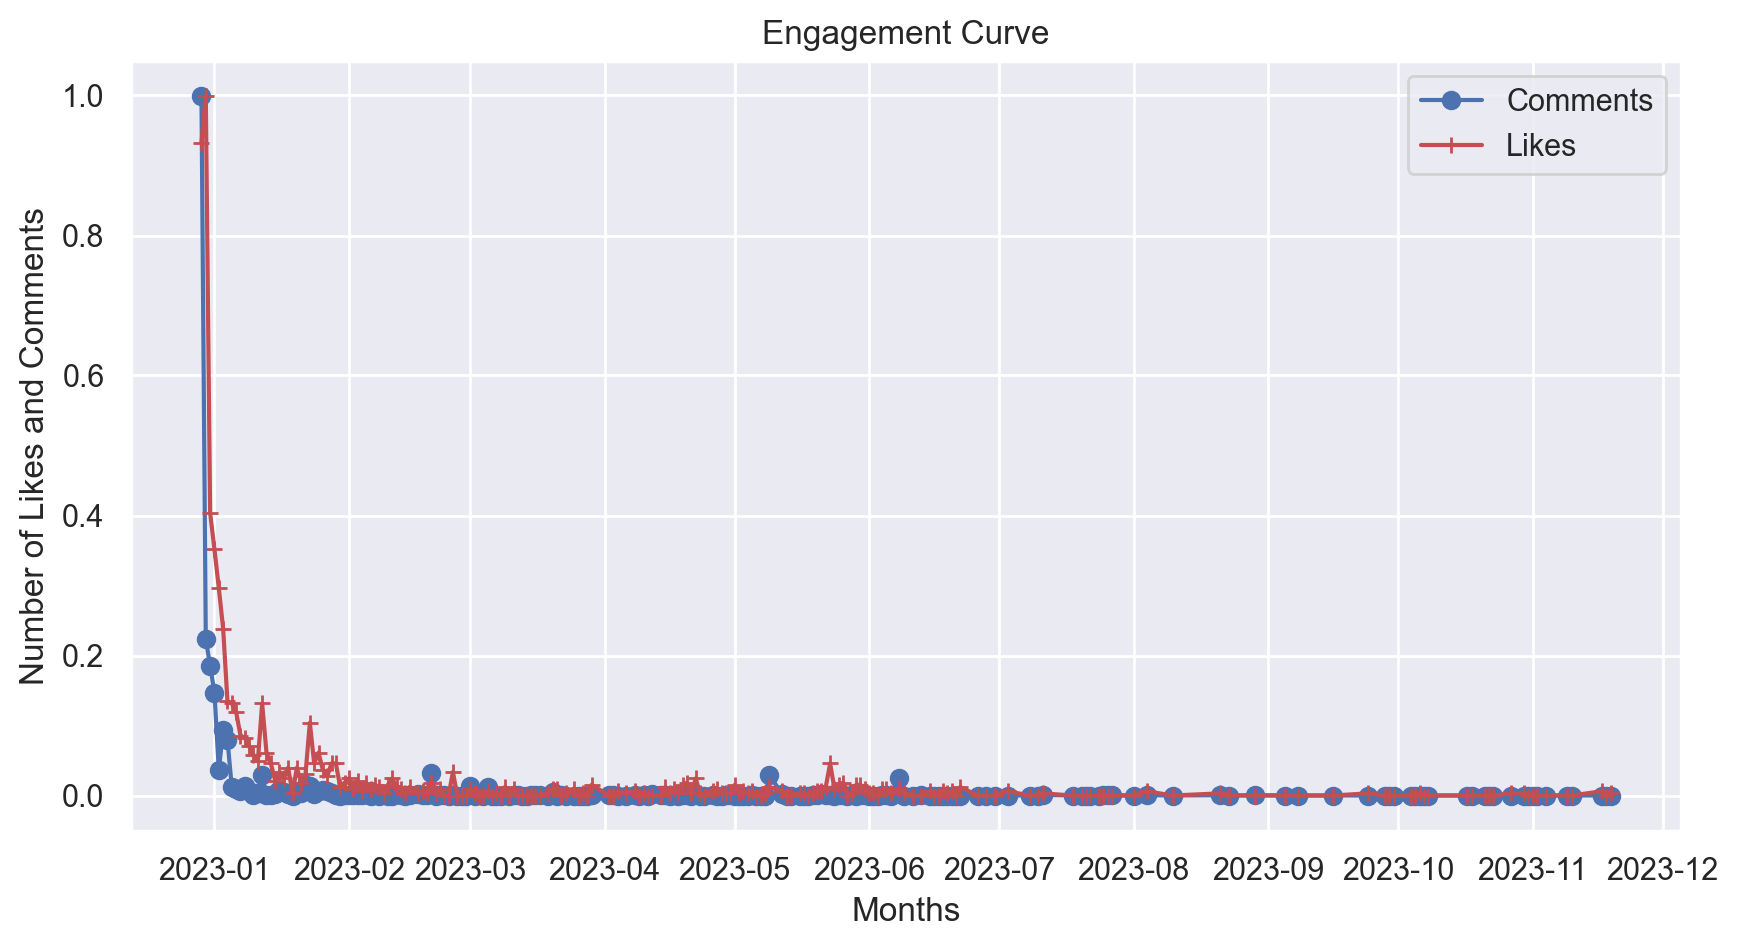

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(
    normalized_comments_over_time.index,
    normalized_comments_over_time.published_at,
    marker="o",
    linestyle="-",
    color="b",
    label="Comments",
)
plt.plot(
    normalized_comments_over_time.index,
    normalized_comments_over_time.likes,
    marker="+",
    linestyle="-",
    color="r",
    label="Likes",
)
plt.title("Engagement Curve")
plt.xlabel("Months")
plt.ylabel("Number of Likes and Comments")
plt.legend()
plt.grid(True)
plt.show()